$\newcommand{L}[1]{\| #1 \|}\newcommand{VL}[1]{\L{ \vec{#1} }}\newcommand{R}[1]{\operatorname{Re}\,(#1)}\newcommand{I}[1]{\operatorname{Im}\, (#1)}$

## The General Linear Model for one voxel

In [28]:
%matplotlib inline

Start with our usual imports:

In [29]:
import numpy as np
import matplotlib.pyplot as plt
import nibabel as nib
# Only show 6 decimals when printing
np.set_printoptions(precision=6)

Load the 4D image ready for analysis:

In [30]:
img = nib.load('ds114_sub009_t2r1.nii')
img.shape

(64, 64, 30, 173)

# Getting the convolved regressor

## Using scipy

*Scipy* is a large library of scientific routines that builds on top of numpy.

You can think of numpy as being a subset of MATLAB, and numpy + scipy as being
as being roughly equivalent to MATLAB plus the MATLAB toolboxes.

Scipy has many sub-packages, for doing things like reading MATLAB `.mat`
files (`scipy.io`) or working with sparse matrices (`scipy.sparse`). We
are going to be using the functions and objects for working with statistical
distributions in `scipy.stats`:

In [31]:
import scipy.stats

`scipy.stats` contains objects for working with many different
distributions. We are going to be working with `scipy.stats.gamma`, which
implements the [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution).

In [32]:
from scipy.stats import gamma

In particular we are interested in the [probability density function](https://en.wikipedia.org/wiki/Probability_density_function) (PDF) of the
gamma distribution.

Because this is a function, we need to pass it an array of values at
which it will evaluate.

We can also pass various parameters which change the shape, location and width
of the gamma PDF. The most important is the first parameter (after the input
array) known as the [shape parameter](https://en.wikipedia.org/wiki/Shape_parameter) ($k$ in the
[wikipedia page on gamma distributions](https://en.wikipedia.org/wiki/Gamma_distribution)).

First we chose some x values at which to sample from the gamma PDF:

In [33]:
x = np.arange(0, 25, 0.1)

Next we plot the gamma PDF for shape values of 2, 4, 8, 12.

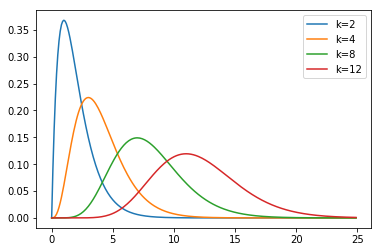

In [34]:
plt.plot(x, gamma.pdf(x, 2), label='k=2')
plt.plot(x, gamma.pdf(x, 4), label='k=4')
plt.plot(x, gamma.pdf(x, 8), label='k=8')
plt.plot(x, gamma.pdf(x, 12), label='k=12')
plt.legend()

# Constructing a hemodynamic response function

We can use these gamma functions to construct a continuous function that is
close to the hemodynamic response we observe for a single brief event in the
brain.

Our function will accept an array that gives the times we want to calculate
the HRF for, and returns the values of the HRF for those times.  We will
assume that the true HRF starts at zero, and gets to zero sometime before 35
seconds.

We’re going to try using the sum of two [gamma distribution](https://en.wikipedia.org/wiki/Gamma_distribution) probability density
functions.

Here is one example of such a function:

In [35]:
def hrf(times):
    """ Return values for HRF at given times """
    # Gamma pdf for the peak
    peak_values = gamma.pdf(times, 6)
    # Gamma pdf for the undershoot
    undershoot_values = gamma.pdf(times, 12)
    # Combine them
    values = peak_values - 0.35 * undershoot_values
    # Scale max to 0.6
    return values / np.max(values) * 0.6

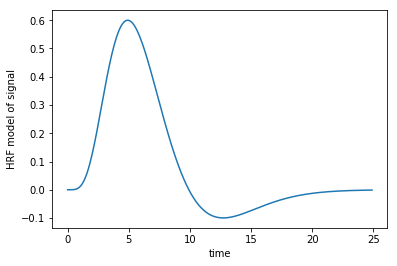

In [36]:
plt.plot(x, hrf(x))
plt.xlabel('time')
plt.ylabel('HRF model of signal')

We can sample from the function, to get the estimates at the times of our TRs.
Remember, the TR is 2.5 for our example data, meaning the scans were 2.5
seconds apart.

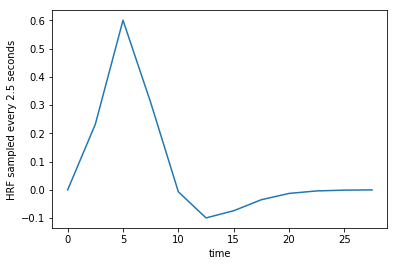

In [37]:
TR = 2.5
tr_times = np.arange(0, 30, TR)
hrf_at_trs = hrf(tr_times)
len(hrf_at_trs)
plt.plot(tr_times, hrf_at_trs)
plt.xlabel('time')
plt.ylabel('HRF sampled every 2.5 seconds')

# Making the convolved regressor

We can use this to convolve our neural (on-off) prediction.  This will give us
a hemodynamic prediction, under the linear-time-invariant assumptions of the
convolution.  You will recognize this snippet from the
`first_activation.ipynb` notebook:

In [38]:
#- Make new zero vector for neural prediction
neural_prediction = np.zeros(img.shape[-1])
#- Read the file into an array called "task".
#- "task" should have 3 columns (onset, duration, amplitude)
task = np.loadtxt('ds114_sub009_t2r1_cond.txt')
#- Select first two columns and divide by TR
ons_durs = task[:, :2] / TR
#- Fill in values of 1 for positions of on blocks in time course
# Convert onsets, durations to integers first
ons_durs = np.round(ons_durs).astype(int)
for onset, duration in ons_durs:
    neural_prediction[onset:onset + duration] = 1

Plot the on-off neural predictor:

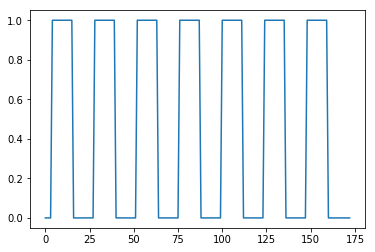

In [40]:
all_tr_times = np.arange(173)
plt.plot(all_tr_times, neural_prediction)

When we convolve, the output is length N + M-1, where N is the number of
values in the vector we convolved, and M is the length of the convolution
kernel (`hrf_at_trs` in our case).  For a reminder of why this is, see the
[tutorial on convolution](https://matthew-brett.github.io/teaching/on_convolution.html).

In [41]:
convolved = np.convolve(neural_prediction, hrf_at_trs)
N = len(neural_prediction)  # M == n_vols == 173
M = len(hrf_at_trs)  # M == 12
len(convolved) == N + M - 1

True

This is because of the HRF convolution kernel falling off the end of the input
vector. The value at index 172 in the new vector refers to time 172 \* 2.5 =
430.0 seconds, and value at index 173 refers to time 432.5 seconds, which is
just after the end of the scanning run. To retain only the values in the new
hemodynamic vector that refer to times up to (and including) 430s, we can just
drop the last `len(hrf_at_trs) - 1 == M - 1` values:

In [42]:
n_to_remove = len(hrf_at_trs) - 1
convolved = convolved[:-n_to_remove]

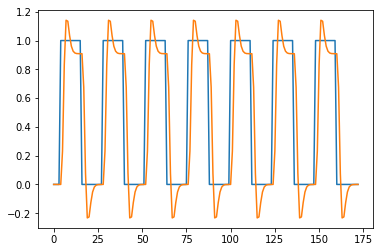

In [43]:
plt.plot(all_tr_times, neural_prediction)
plt.plot(all_tr_times, convolved)

# Using the convolved regressor in the linear model

We get the image data, and knock off the first four volumes to remove the artefact
we discovered in First go at brain activation exercise:

In [44]:
data = img.get_data()
data = data[..., 4:]

The voxel coordinate (3D coordinate) that we were looking at in
Voxel time courses was at (42, 32, 19):

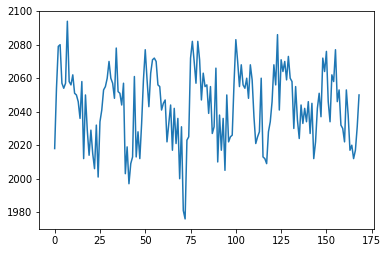

In [45]:
voxel_time_course = data[42, 32, 19]
plt.plot(voxel_time_course)

Now we are going to use the convolved regressor we just made to do a simple
regression on this voxel time course.

First drop the first four elements of the convolved regressor, to match the
four volumes we dropped from the image data:

In [46]:
# Drop the first four volumes-worth from the regressor
convolved = convolved[4:]
len(convolved)

169

Next we make our *design matrix*.  It has a column for the convolved
regressor, and a column of ones:

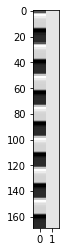

In [47]:
N = len(convolved)
X = np.ones((N, 2))
X[:, 0] = convolved
plt.imshow(X, interpolation='nearest', cmap='gray', aspect=0.1)

$\newcommand{\yvec}{\vec{y}}$
$\newcommand{\xvec}{\vec{x}}$
$\newcommand{\evec}{\vec{\varepsilon}}$
$\newcommand{Xmat}{\boldsymbol X} \newcommand{\bvec}{\vec{\beta}}$
$\newcommand{\bhat}{\hat{\bvec}} \newcommand{\yhat}{\hat{\yvec}}$

As you will remember from the [introduction to the General Linear Model](https://matthew-brett.github.io/teaching/glm_intro.html), our
model is:

$$
\yvec = \Xmat \bvec + \evec
$$

We can get our least squares parameter *estimates* for $\bvec$ with:

$$
\bhat = \Xmat^+y
$$

where $\Xmat^+$ is the *pseudoinverse* of $\Xmat$.  When $\Xmat$ is
invertible, the pseudoinverse is given by:

$$
\Xmat^+ = (\Xmat^T \Xmat)^{-1} \Xmat^T
$$

Let’s calculate the pseudoinverse for our design:

In [48]:
import numpy.linalg as npl
Xp = npl.pinv(X)
Xp.shape

(2, 169)

We calculate $\bhat$:

In [49]:
beta_hat = Xp.dot(voxel_time_course)
beta_hat

array([   31.185514,  2029.367685])

We can then calculate $\yhat$ (also called the *fitted data*):

41405.5727762


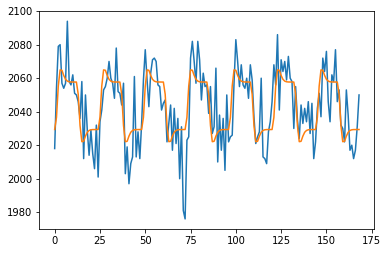

In [50]:
y_hat = X.dot(beta_hat)
e_vec = voxel_time_course - y_hat
print(np.sum(e_vec ** 2))
plt.plot(voxel_time_course)
plt.plot(y_hat)

# Doing a t-test on the linear model fit

Our plan now is to do an hypothesis test on our $\bhat$ values.

The $\bhat$ values are sample estimates of the unobservable true $\bvec$
parameters.

Because the $\bhat$ values are sample estimates, the values we have depend on
the particular sample we have, and the particular instantiation of the random
noise (residuals).   If we were to take another set of data from the same
voxel during the same task, we would get another estimate, because there would
be different instantiation of the random noise.  It’s possible to show that
the variance / covariance of the $\hat\beta$ estimates is:

$$
\text{Cov}(\hat\beta) = \sigma^2 \left(X^T X\right)^{-1}.
$$

where $\sigma^2$ is the true unknown variance of the errors. See [wikipedia
proof](https://en.wikipedia.org/wiki/Proofs_involving_ordinary_least_squares#Unbiasedness_of_.CE.B2.CC.82),
and [stackoverflow proof](http://stats.stackexchange.com/questions/72940/covariance-matrix-of-least-squares-estimator-hat-beta).

We can use an estimate $\hat\sigma^2$ of $\sigma^2$ to give us estimated
standard errors of the variance covariance (see: Unbiased estimate of population variance):

In [51]:
y = voxel_time_course
y_hat = X.dot(beta_hat)
residuals = y - y_hat
# Residual sum of squares
RSS = np.sum(residuals ** 2)
# Degrees of freedom: n - no independent columns in X
df = X.shape[0] - npl.matrix_rank(X)
# Mean residual sum of squares
MRSS = RSS / df
# This is our s^2
s2_hat = MRSS
print(s2_hat)
print(np.sqrt(s2_hat))

247.937561534
15.7460332


We now have an standard estimate of the variance / covariance of the $\bhat$:

In [52]:
v_cov = s2_hat * npl.inv(X.T.dot(X))

In particular, I can now divide my estimate for the first parameter, by the
standard error of that estimate:

In [53]:
numerator = beta_hat[0]
denominator = np.sqrt(v_cov[0, 0])
t_stat = numerator / denominator
print(t_stat)

12.8267805905


I can look up the probability of this t statistic using `scipy.stats`:

In [54]:
from scipy.stats import t as t_dist
# Get p value for t value using cumulative density dunction
# (CDF) of t distribution
ltp = t_dist.cdf(t_stat, df) # lower tail p
p = 1 - ltp # upper tail p
p

0.0

In [55]:
np.savetxt('ds114_sub009_t2r1_conv.txt', convolved)
np.savetxt('voxel_time_course.txt', voxel_time_course)

Here are the commands to run the same analysis in R:

```
# Simple regression model in R
# Load the voxel time course
voxels = read.table('voxel_time_course.txt')$V1
# Load the convolved regressor
convolved = read.table('ds114_sub009_t2r1_conv.txt')$V1
# Fit linear model
res = lm(voxels ~ convolved)
print(summary(res))
```